In [29]:
from model import MLPClassifier
from dataloader import get_dataloader
import numpy as np
from utils import simple_accuracy
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import matthews_corrcoef
from data import dataset
import itertools
from tqdm.notebook import tqdm
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
import pandas as pd

In [3]:
DATA_PATH = dataset
LABEL_COLUMN = 'GDvsTI'
EPOCHS = 100
N_BOOTSTRAPS = 100
features = ['eGFR_CKDEPI2021', 'age', "SeqId_10011_65", "SeqId_10024_44", "SeqId_10040_63", "SeqId_10042_8"]
param_grid = {
    'lr': [1e-2, 1e-3, 1e-4],
    'batch_size': [8, 16, 32],
    'hidden_dims': [(32,), (64, 32), (128, 64, 32)]
}

In [4]:
# Hyperparameter grid
param_grid = {
    'lr': [1e-2, 1e-3, 1e-4],
    'batch_size': [8, 16, 32],
    # Add other hyperparameters here...
}

In [27]:
def load_data():
    print(f"Loading data from: {DATA_PATH}")
    dataloader = get_dataloader(DATA_PATH, LABEL_COLUMN, batch_size=32, features=features)
    print(f"Dataloader: {dataloader}")
    X, y = [], []
    for batch_input, batch_label in dataloader:
        X.append(batch_input.numpy())
        y.append(batch_label.numpy())
    
    return np.vstack(X), np.hstack(y)

In [32]:
# load_data()
df = pd.read_csv(dataset)
# print(csv.columns)
columns_to_write = [col for col in df.columns if col != "GDvsTI"]

# Write the columns to a text file
with open('columns.txt', 'w') as f:
    for col in columns_to_write:
        f.write(str(columns_to_write))

In [6]:
def grid_search_train(X, y):
    best_mcc = -np.inf
    best_params = None
    
    # Lists to store metrics for each bootstrap iteration
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    mccs = []
    rocs = []
    pr_curves = []

    # Generate all combinations of hyperparameters
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    for i in tqdm(range(N_BOOTSTRAPS)):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4)

        for params in param_combinations:
            model = MLPClassifier(**params)
            model.fit(X_train, y_train)
            predictions = model.predict(X_val)
            
            # Compute metrics
            accuracy = accuracy_score(y_val, predictions)
            precision = precision_score(y_val, predictions)
            recall = recall_score(y_val, predictions)
            f1 = f1_score(y_val, predictions)
            mcc = matthews_corrcoef(y_val, predictions)
            fpr, tpr, _ = roc_curve(y_val, predictions)
            precision_curve, recall_curve, _ = precision_recall_curve(y_val, predictions)
            
            # Store metrics
            accuracies.append(accuracy)
            precisions.append(precision)
            recalls.append(recall)
            f1s.append(f1)
            mccs.append(mcc)
            rocs.append((fpr, tpr))
            pr_curves.append((precision_curve, recall_curve))
            
            if mcc > best_mcc:
                best_mcc = mcc
                best_params = params
                
    # Compute mean and standard deviation for each metric
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    mean_precision = np.mean(precisions)
    std_precision = np.std(precisions)
    mean_recall = np.mean(recalls)
    std_recall = np.std(recalls)
    mean_f1 = np.mean(f1s)
    std_f1 = np.std(f1s)
    mean_mcc = np.mean(mccs)
    std_mcc = np.std(mccs)
    
    return best_mcc, best_params, mean_accuracy, std_accuracy, mean_precision, std_precision, mean_recall, std_recall, mean_f1, std_f1, mean_mcc, std_mcc


In [17]:
def plot_importances(model, X, y):
    result = permutation_importance(model, X, y, n_repeats=30, random_state=0)
    importances = result.importances_mean
    print("importances: ", importances)
    std = result.importances_std
    indices = np.argsort(importances)[::-1]
    print([importances[i] for i in indices])

    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), np.array(features)[indices], rotation=45, ha="right")
    plt.xlim([-1, X.shape[1]])
    plt.show()

In [15]:
X, y = load_data()
def train_model():
    
    best_score, best_params, mean_accuracy, std_accuracy, mean_precision, std_precision, mean_recall, std_recall, mean_f1, std_f1, mean_mcc, std_mcc = grid_search_train(X, y)
    
    print(f"Best Score (MCC): {best_score}")
    print(f"Best Parameters: {best_params}")
    print(f"Mean Accuracy: {mean_accuracy} ± {std_accuracy}")
    print(f"Mean Precision: {mean_precision} ± {std_precision}")
    print(f"Mean Recall: {mean_recall} ± {std_recall}")
    print(f"Mean F1 Score: {mean_f1} ± {std_f1}")
    print(f"Mean MCC: {mean_mcc} ± {std_mcc}")
    
    # Train final model with best parameters on the entire dataset
    model = MLPClassifier(**best_params)
    model.fit(X, y)
    return model


Loading data from: ./data/kidney_data_final_9.18.23.csv
Features: ['eGFR_CKDEPI2021', 'age', 'SeqId_10011_65', 'SeqId_10024_44', 'SeqId_10040_63', 'SeqId_10042_8']
Label: GDvsTI
dataset.py features:  ['eGFR_CKDEPI2021', 'age', 'SeqId_10011_65', 'SeqId_10024_44', 'SeqId_10040_63', 'SeqId_10042_8']
self.label:  GDvsTI
self.content after filtering:  1
self.x:  [[36.       27.540041 11.332205 10.551516  8.871289  9.807516]
 [64.       52.900753 11.26092   9.368943  9.086667  9.509775]
 [45.       68.3833   11.155451  9.495255  8.844235  9.562433]
 ...
 [ 7.       44.648872 11.84184  11.859729 11.824999  9.809125]
 [39.       49.88912  11.479073  9.371341  8.703212  9.515503]
 [28.       68.952774 11.643631  9.518063  8.836997  9.574972]]
self.y:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 

importances:  [-0.00648567 -0.01055807 -0.00739065 -0.00497738 -0.00558069 -0.0040724 ]
[-0.004072398190045298, -0.00497737556561092, -0.005580693815988007, -0.006485671191553614, -0.007390648567119218, -0.010558069381598844]


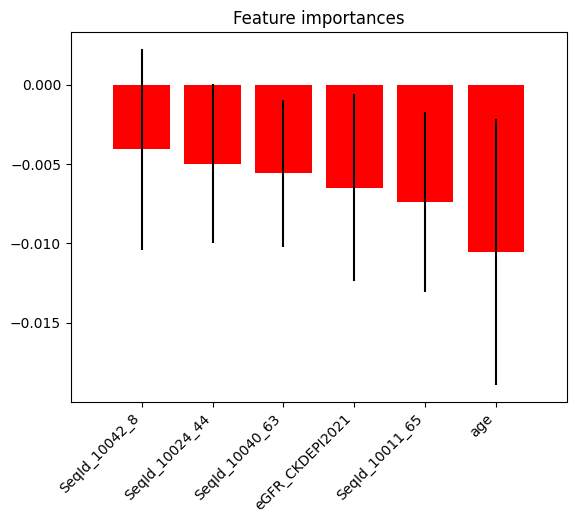

In [18]:
# model = train_model()
# Optional: Save the model
# model.save('./model_weights_sample.pt')
    
# Plot feature importances
plot_importances(model, X, y)

Loading data from: ./data/kidney_data_final_9.18.23.csv
Features: ['eGFR_CKDEPI2021', 'age', 'SeqId_10011_65', 'SeqId_10024_44', 'SeqId_10040_63', 'SeqId_10042_8']
Label: GDvsTI
dataset.py features:  ['eGFR_CKDEPI2021', 'age', 'SeqId_10011_65', 'SeqId_10024_44', 'SeqId_10040_63', 'SeqId_10042_8']
self.label:  GDvsTI
self.content after filtering:  1
self.x:  [[36.       27.540041 11.332205 10.551516  8.871289  9.807516]
 [64.       52.900753 11.26092   9.368943  9.086667  9.509775]
 [45.       68.3833   11.155451  9.495255  8.844235  9.562433]
 ...
 [ 7.       44.648872 11.84184  11.859729 11.824999  9.809125]
 [39.       49.88912  11.479073  9.371341  8.703212  9.515503]
 [28.       68.952774 11.643631  9.518063  8.836997  9.574972]]
self.y:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 

  0%|          | 0/100 [00:00<?, ?it/s]

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best Score (MCC): 0.49735027281476557
Best Parameters: {'lr': 0.001, 'batch_size': 8}
Mean Accuracy: 0.7440948813982522 ± 0.10437326839560557
Mean Precision: 0.7851868432241933 ± 0.06761454759598423
Mean Recall: 0.9271307119335063 ± 0.17946271043736192
Mean F1 Score: 0.8369338209661358 ± 0.1256986420565416
Mean MCC: 0.027649101073039722 ± 0.10137846450164763


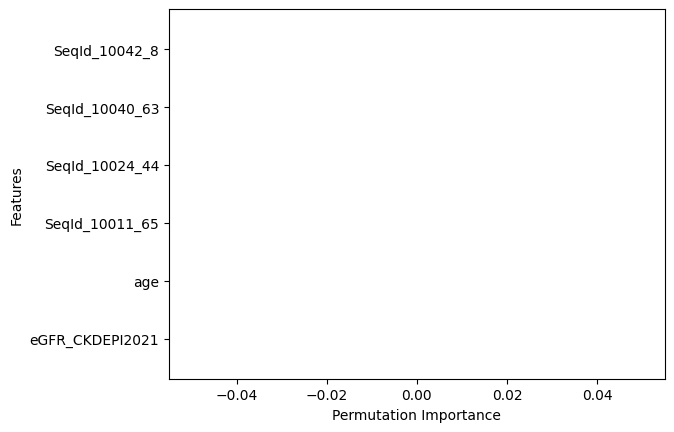

In [11]:
main()